In [1]:
#from pymopt.utils import readDICOM as dcm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pa
#import cv2
import seaborn as sns
sns.set_style("ticks", {'grid.linestyle': '--'})

In [108]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 30 14:08:54 2019

@author: Kaname Miura
"""

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt

workspace = os.getcwd()
os.chdir(workspace)

def readDicom(*,path,size_down=True,ext_name = '.dcm'):
    os.chdir(workspace)
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ext_name in filename.lower(): # 拡張子が.dcmか.magかで書き換える
                lstFilesDCM.append(os.path.join(dirName,filename))
    
    RefDs = dicom.read_file(lstFilesDCM[0],force=True) # DICOMの先頭ファイルはヘッダとなる
    RefDs.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
    
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.PixelSpacing[1]))
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
    
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    
    # すべてのDICOMファイルに対して読み込む
    for filenameDCM in lstFilesDCM:
        ds = dicom.read_file(filenameDCM,force=True)
        ds.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array
    if size_down:
        ArrayDicom = changeResolution(ArrayDicom,ConstPixelDims)
        
    print("ConstPixelDims: %s"%str(ConstPixelDims))
    print("ConstPixelSpacing: %s"%str(ConstPixelSpacing))
    print("Data infomation")
    print(RefDs)
    os.chdir(workspace)
    return ArrayDicom,[x,y,z],ConstPixelDims,ConstPixelSpacing
    
def changeResolution(x,ConstPixelDims):
    #解像度を16bitから8bitに変更します。
    a = x.shape
    x = x.reshape(-1,ConstPixelDims[2])
    x = np.array([np.round(i/(2**8)).astype('int8') for i in x])
    return np.array(x).reshape(a[0],a[1],a[2])

def reConstArray(ArrayDicom,threshold=9500):
    threshold = round(threshold/(2**8))
    return np.where(ArrayDicom < threshold, 0, ArrayDicom)

def displayGraph(ArrayDicom,resol0,resol1):
    plt.figure(figsize=(6,6),dpi=90)
    plt.axes().set_aspect('equal', 'datalim')
    plt.set_cmap(plt.gray())
    plt.pcolormesh(resol0,resol1, ArrayDicom[:, :,0])
    plt.xlabel("X mm")
    plt.ylabel("Y mm")
    plt.xlim(np.min(resol0),np.max(resol0))
    plt.ylim(np.min(resol1),np.max(resol1))
    plt.show()
    
# 表示

#pathdcom = "DICOMfile9" 
#ArrayDicom,resolution,ConstPixelDims = readDicom(pathdcom)
#ArrayDicom = reConstArray(ArrayDicom)

             


In [3]:
array_dicom,resolution,ConstPixelDims,ConstPixelSpacing = readDicom(path = 'DICOMfile9')

ConstPixelDims: (1024, 1024, 88)
ConstPixelSpacing: (0.0274828696451, 0.0274828696451, 0.0274828696451)
Data infomation
Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ['', 'ISO 2022 IR 87']
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9110..1.11.201701271719590407
(0008, 0020) Study Date                          DA: '20170127'
(0008, 0021) Series Date                         DA: '20170127'
(0008, 0022) Acquisition Date                    DA: '20170127'
(0008, 0023) Content Date                        DA: '20170127'
(0008, 0030) Study Time                          TM: '165759.0000'
(0008, 0031) Series Time                        

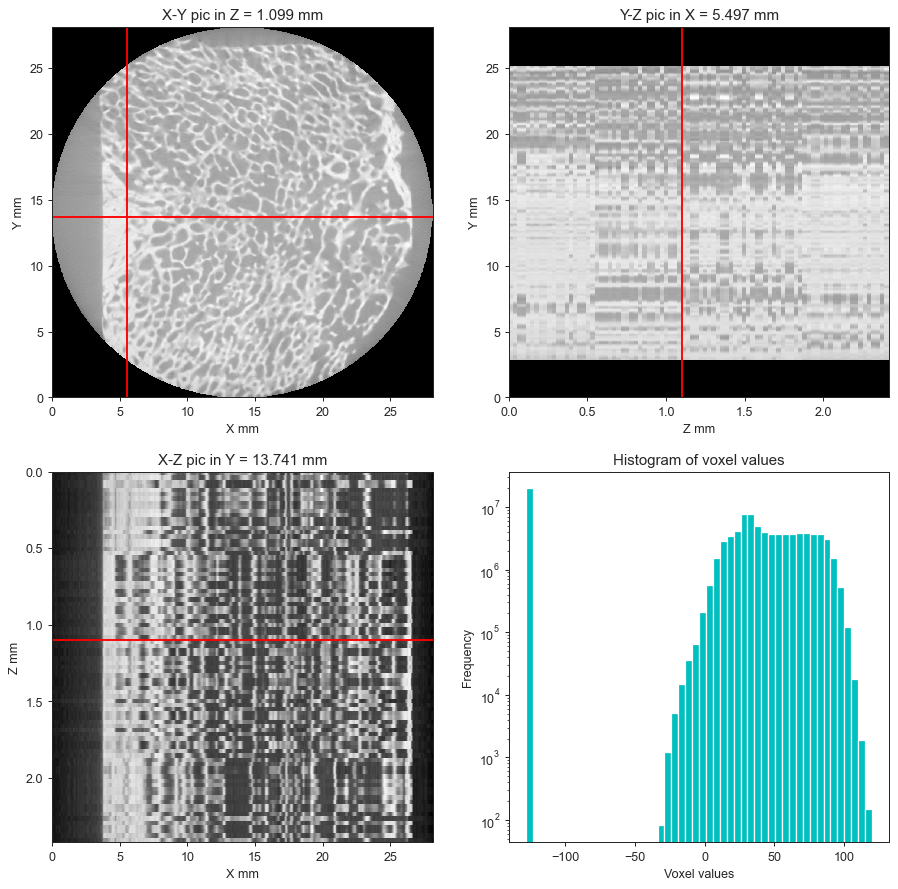

In [150]:
def display_cross_section(image,*,xx = 0,yy = 0,zz = 0,
                          int_pix = True, section_line = True, cmap = 'gray'):
    if int_pix:
        x_size = xx*ConstPixelSpacing[0] 
        y_size = yy*ConstPixelSpacing[1]
        z_size = zz*ConstPixelSpacing[2]
    else:
        x_size = xx
        y_size = yy
        z_size = zz
        xx = int(x_size/ConstPixelSpacing[0])
        yy = int(y_size/ConstPixelSpacing[1])
        zz = int(z_size/ConstPixelSpacing[2])
        
    resol0 = [ConstPixelSpacing[0]*i for i in range(image.shape[0]+1)]
    resol1 = [ConstPixelSpacing[1]*i for i in range(image.shape[1]+1)]
    resol2 = [ConstPixelSpacing[2]*i for i in range(image.shape[2]+1)]
    
    fig,ax = plt.subplots(2,2,figsize=[12,12],dpi=90)
    plt.set_cmap(plt.get_cmap(cmap))
    ax[0,0].set_title('X-Y pic in Z = %0.3f mm' %(z_size))
    ax[0,0].pcolormesh(resol1,resol0,image[:,:,zz])
    ax[0,0].set_xlabel("X mm")
    ax[0,0].set_ylabel("Y mm")

    ax[0,1].set_title('Y-Z pic in X = %0.3f mm' %(x_size))
    ax[0,1].pcolormesh(resol2,resol0,image[:,xx,:])
    ax[0,1].set_xlabel("Z mm")
    ax[0,1].set_ylabel("Y mm")
    
    ax[1,0].set_title('X-Z pic in Y = %0.3f mm' %(y_size))
    ax[1,0].pcolormesh(resol1,resol2,image[yy,:,:].T)
    ax[1,0].set_ylim(resol2[-1],resol2[0])
    ax[1,0].set_xlabel("X mm")
    ax[1,0].set_ylabel("Z mm")
    
    ax[1,1].set_title('Histogram of voxel values')
    ax[1,1].hist(image.flatten(),bins=50, color='c')
    ax[1,1].set_yscale('log')
    ax[1,1].set_xlabel("Voxel values")
    ax[1,1].set_ylabel("Frequency")
    
    if section_line:
        ax[0,0].plot([x_size,x_size],[0,resol0[-1]],'-',c = 'r')
        ax[0,0].plot([0,resol1[-1]],[y_size,y_size],'-',c = 'r')
        ax[0,1].plot([z_size,z_size],[0,resol0[-1]],'-',c = 'r')
        ax[1,0].plot([0,resol1[-1]],[z_size,z_size],'-',c = 'r')
        
    plt.show()
    
display_cross_section(array_dicom,zz = 40,yy = 500,xx = 200)

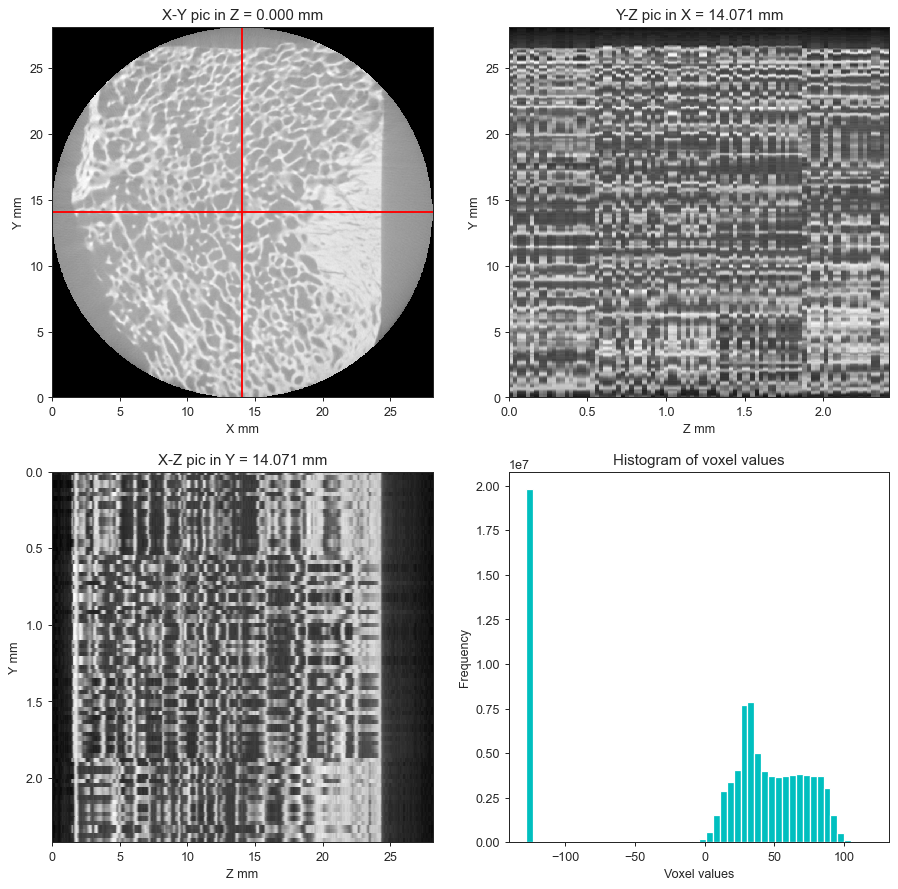

In [126]:
def rot180_xz(image,cmap = 'gray'):
    image = np.flip(image)
    image = np.flipud(image)
    display_cross_section(image,zz = 0,
                          xx = int(image.shape[0]/2),
                          yy = int(image.shape[1]/2),
                          cmap = cmap)
rot180_xz(array_dicom)

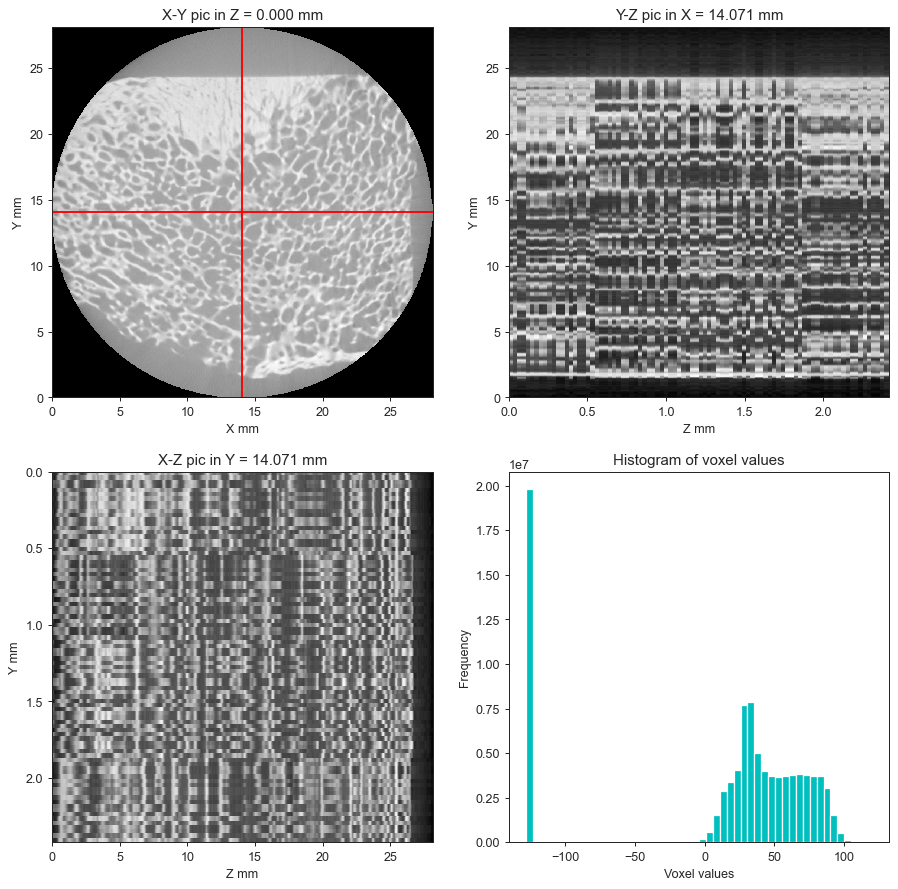

In [134]:
def rot90_xy(image,k=1,cmap='gray'):
    image = np.rot90(image,k=k)
    display_cross_section(image,zz = 0,
                          xx = int(image.shape[0]/2),
                          yy = int(image.shape[1]/2),
                          cmap = cmap)
rot90_xy(array_dicom,1)

Trimming parameters


,right,left,upper,lower,top,bottom
Pixel number,72,145,72,0,18,18
Position [mm],1.979,3.985,1.979,0,0.495,0.495


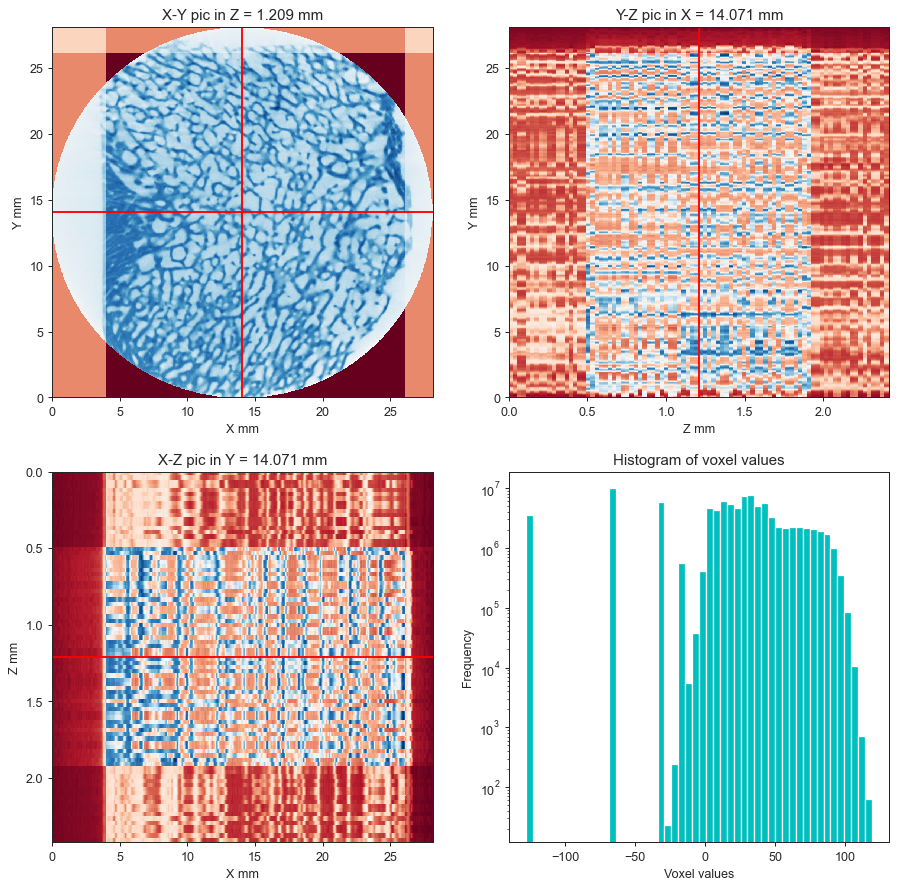

In [156]:

def trim_area(image,*, right = 1, left = 1,
              upper = 1,lower = 1,
              top = 0,bottom = 0,
              int_pix = True,cmap = 'gray'):
    
    img = image.copy()
    resol = resolution
    
    if int_pix:
        right = right*-1
        upper = upper*-1
    else:
        right = int(right/ConstPixelSpacing[0])*-1
        left = int(left/ConstPixelSpacing[0])
        upper = int(upper/ConstPixelSpacing[1])*-1
        lower = int(lower/ConstPixelSpacing[1])
        bottom = int(bottom/ConstPixelSpacing[2])*-1
        top = int(top/ConstPixelSpacing[2])
        
    d_rate = 2
    for i,po in enumerate([upper,right,bottom]):
        if i == 0:
            if po != 0:
                img[po:,:,:] = img[po:,:,:]/d_rate
        elif i == 1:
            if po != 0:
                img[:,po:,:] = img[:,po:,:]/d_rate
        elif i == 2:
            if po != 0:
                img[:,:,po:] = img[:,:,po:]/d_rate
    img[:lower,:,:] = img[:lower,:,:]/d_rate
    img[:,:left,:] = img[:,:left,:]/d_rate
    img[:,:,:top] = img[:,:,:top]/d_rate
    
    df = pa.DataFrame(columns = ['right','left','upper','lower','top','bottom'])
    df_array = np.array([right,left,upper,lower,top,bottom])
    df.loc['Pixel number'] = df_array
    df.loc['Position [mm]'] = np.round(df_array*ConstPixelSpacing[0],3)
    print('Trimming parameters')
    display(abs(df))
    
    display_cross_section(img,zz = int(img.shape[2]/2),
                          xx = int(image.shape[0]/2),
                          yy = int(image.shape[1]/2),
                          cmap = cmap)

    
trim_area(array_dicom, right = 2,left = 4,upper = 2,lower = 0,
                  top = 0.5,bottom = 0.5,int_pix = False,cmap = 'RdBu') 

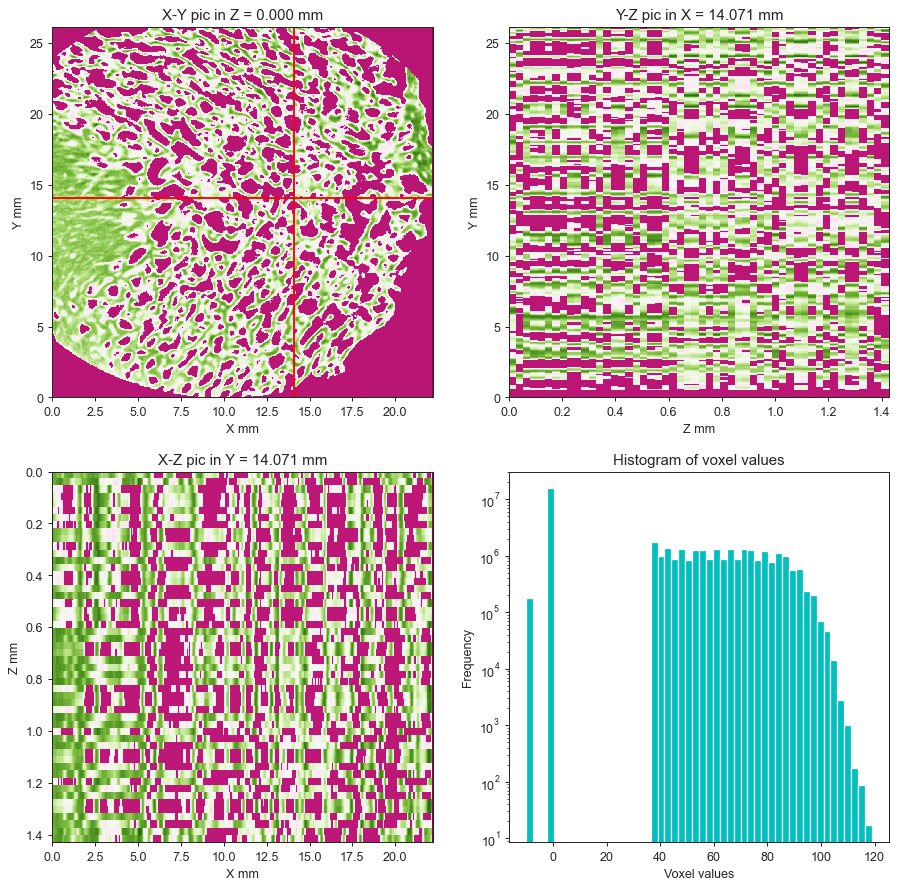

#########  Size  #########
Image shape was changed
from (1024,1024,88)
 to  (952,807,52)



In [160]:
def trim(image,*, right = 20, left = 1,
              upper = 1,lower = 1,
              top = 0,bottom = 0,
              int_pix = True,cmap = 'gray'):
    img = image.copy()
    resol = resolution
    img = reConstArray(img,threshold=9500)
    if int_pix:
        right = right*-1
        upper = upper*-1
    else:
        right = int(right/ConstPixelSpacing[0])*-1
        left = int(left/ConstPixelSpacing[0])
        upper = int(upper/ConstPixelSpacing[1])*-1
        lower = int(lower/ConstPixelSpacing[1])
        bottom = int(bottom/ConstPixelSpacing[2])*-1
        top = int(top/ConstPixelSpacing[2])
        
    d_num = -10
    for i,po in enumerate([upper,right,bottom]):
        if i == 0:
            if po != 0:
                img[po:,:,:] = d_num
        elif i == 1:
            if po != 0:
                img[:,po:,:] = d_num
        elif i == 2:
            if po != 0:
                img[:,:,po:] = d_num
    img[:lower,:,:] = d_num
    img[:,:left,:] = d_num
    img[:,:,:top] = d_num
    
    img_shape = img.shape
    
    img = img.ravel()
    index = np.where(img==d_num)[0]
    img = np.delete(img,index)
    L0 = ConstPixelDims[0]-abs(lower)-abs(upper)
    L1 = ConstPixelDims[1]-abs(left)-abs(right)
    L2 = ConstPixelDims[2]-abs(top)-abs(bottom)
    img = img.reshape([L0,L1,L2])

    resol0 = [ConstPixelSpacing[0]*i for i in range(img.shape[0]+1)]
    resol1 = [ConstPixelSpacing[1]*i for i in range(img.shape[1]+1)]

    img[0,:,:] = -10
    img[-1,:,:] = -10
    img[:,0,:] = -10
    img[:,-1,:] = -10
    display_cross_section(img,zz = 0,
                          xx = int(image.shape[0]/2),
                          yy = int(image.shape[1]/2),
                          cmap = cmap)
    
    print("#########  Size  #########")
    print('Image shape was changed')
    print('from (%d,%d,%d)' %img_shape)
    print(' to  (%d,%d,%d)' %img.shape)
    print()
    

trim(array_dicom, right = 2,left = 4,upper = 2,lower = 0,
                  top = 0.5,bottom = 0.5,int_pix = False,cmap = 'PiYG') 

In [89]:
np.where(np.isnan(array_dicom))[0]

array([], dtype=int64)

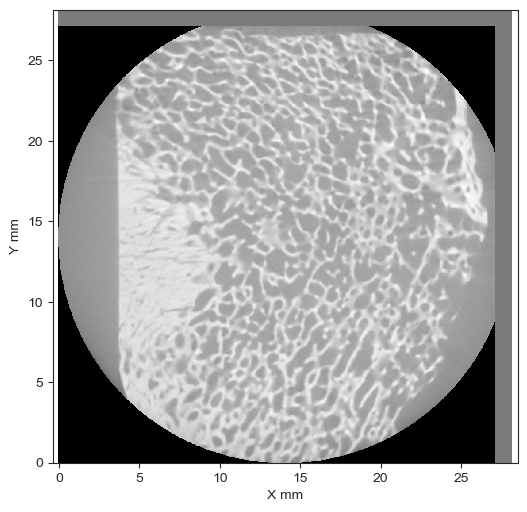

In [9]:
right = 0; left = 0; upper = 0;lower = 0
resol = resolution
image = array_dicom.copy()
ConstPixelSpacing[0]
#image = reConstArray(image,threshold=9500)

right = int(right/ConstPixelSpacing[0])*-1
left = int(left/ConstPixelSpacing[0])
upper = int(upper/ConstPixelSpacing[0])*-1
lower = int(lower/ConstPixelSpacing[0])

if right == 0:
    right = -1
if upper == 0:
    upper = -1
image[:lower,:,:] = -10
image[upper:,:,:] = -10
image[:,right:,:] = -10
image[:,:left,:] = -10
img_shape = image.shape
displayGraph(image,resol[0],resol[1],)

In [135]:
print('(%d,%d,%d)'%array_dicom.shape)

(1024,1024,88)


In [83]:
image = reConstArray(array_dicom,threshold=9500)
np.delete(image,(0,100),axis = 0).shape

(1022, 1024, 88)

In [72]:
resolution[0].shape


(1025,)

In [104]:
a = np.ones((20,20,20))
a[:2,:,:] = 2
a[2,:,:] = 3
b = np.delete(a,slice(0,10),0).shape
a.ravel().shape

(8000,)

In [99]:
index = np.where(a.ravel()==2)[0]
np.delete(a.ravel(),index).reshape([18, 20, 20])

array([[[3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        ...,
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.],
        [3., 3., 3., ..., 3., 3., 3.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

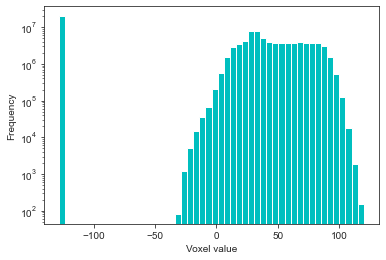

In [36]:
plt.hist(array_dicom.flatten(), bins=50, color='c')
plt.xlabel("Voxel value")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

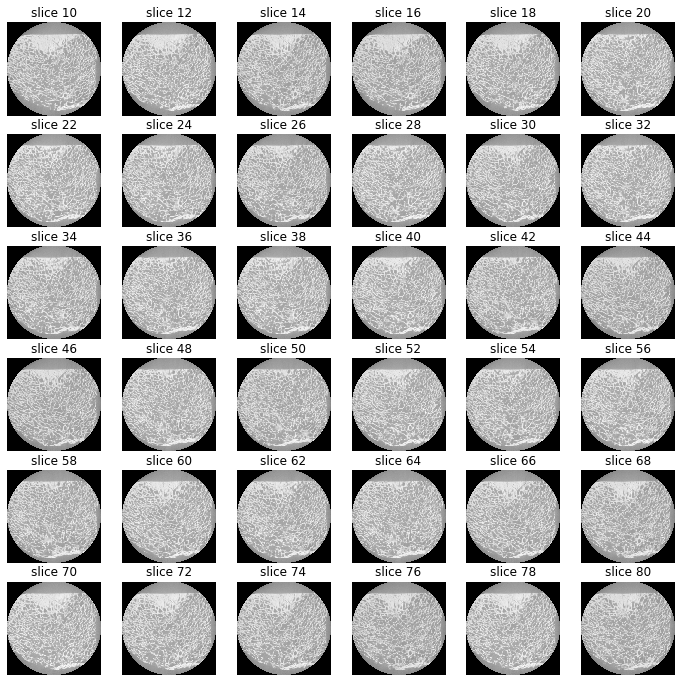

In [6]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=2):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
sample_stack(array_dicom.T)

In [9]:
import scipy.ndimage
ConstPixelSpacing
new_spacing = [1,1,1]
image = array_dicom
spacing = map(float, list(ConstPixelSpacing))
spacing = np.array(list(spacing))
resize_factor = spacing / new_spacing
resize_factor
resize_factor = spacing / new_spacing
new_real_shape = image.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / image.shape
new_spacing = spacing / real_resize_factor

image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)


In [10]:
image.shape

(28, 28, 2)

In [11]:
import skimage

In [ ]:

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print "Shape before resampling\t", array_dicom.shape
imgs_after_resamp, spacing = resample(array_dicom, patient, [1,1,1])
print "Shape after resampling\t", imgs_after_resamp.shape

In [12]:
array_dicom = dcm.reConstArray(array_dicom,threshold = 9500)
dcm.displayGraph(array_dicom[:,:,3:],resolution)

NameError: name 'dcm' is not defined

In [6]:

print("Memory area size for voxel storage: %0.3f Mbyte" % (array_dicom.nbytes*1e-6))

Memory area size for voxel storage: 184.549 Mbyte


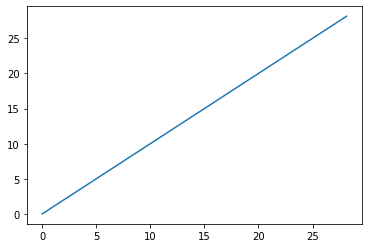

In [25]:
plt.plot(resolution[0],resolution[1])
plt.show()

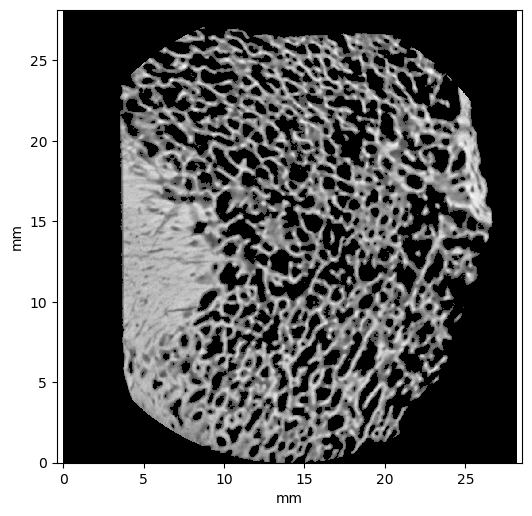

In [25]:
plt.figure(figsize=(6,6),dpi=100)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(resolution[1], resolution[0], array_dicom[:, :,0])
plt.xlabel("mm")
plt.ylabel("mm")
plt.xlim(0,resolution[1].max())
plt.show()

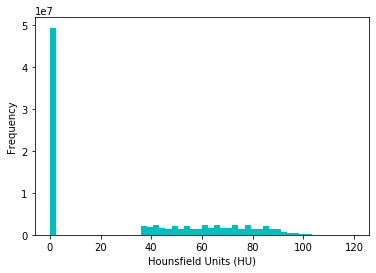

In [56]:
plt.hist(array_dicom.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


In [35]:
array_dicom = np.rot90(array_dicom)

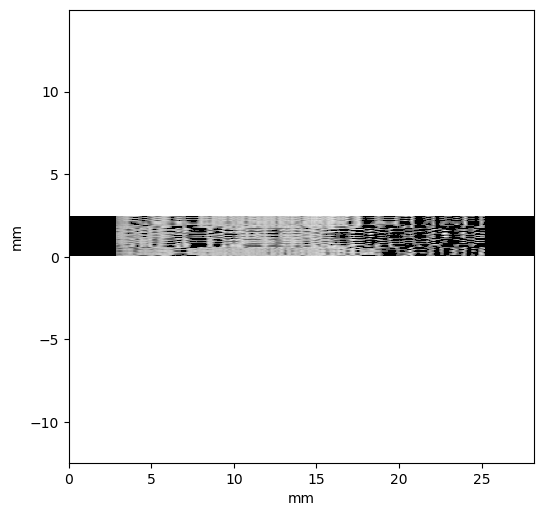

In [50]:

plt.figure(figsize=(6,6),dpi=100)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh( resolution[0], resolution[2][2:],array_dicom[:, 200,:].T)
plt.xlabel("mm")
plt.ylabel("mm")

#plt.xlim(0,resolution[0].max())
plt.show()

In [22]:
array_dicom.shape

(1024, 1024, 88)

In [24]:
a.shape

(1024, 1024, 88)

In [47]:
resolution[2].max()


2.4459753984139003